### Классификация полов по изображениям лиц

In [1]:
import tensorflow as tf
# import torchvision
import tensorflow_datasets as tfds

In [3]:
image_path = './~/tensorflow_datasets'
celeba_dataset = tfds.load('celeb_a:2.0.1', data_dir=image_path,
                           download=False)

In [4]:
celeba_train = celeba_dataset['train']
celeba_valid = celeba_dataset['validation']
celeba_test = celeba_dataset['test']

In [6]:
def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

In [7]:
print(f'train: {count_items(celeba_train)}')
print(f'valid: {count_items(celeba_valid)}')
print(f'test: {count_items(celeba_test)}')

train: 162770
valid: 19867
test: 19962


Будут использоваться 16000 обучающих образцов и 1000 образцов для валидации:

In [8]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

In [10]:
print(f'train: {count_items(celeba_train)}')
print(f'valid: {count_items(celeba_valid)}')

train: 16000
valid: 1000


#### Дополнение данных

Дополнение данных объединяет в себе широкий спектр приемов для обработки сценариев, где обучающие данные ограничены.

Извлечение пяти образцов и применение к пим пяти типов трансформации:
1) обрезка изображения до граничной рамки,
2) переворачивание изображения по горизонтали, 
3) подстройка контрастности, 
4) подстройка яркости 
5) обрезка изображения относительно центра и приведение результирующего изображения к исходному размеру (218, 178). 

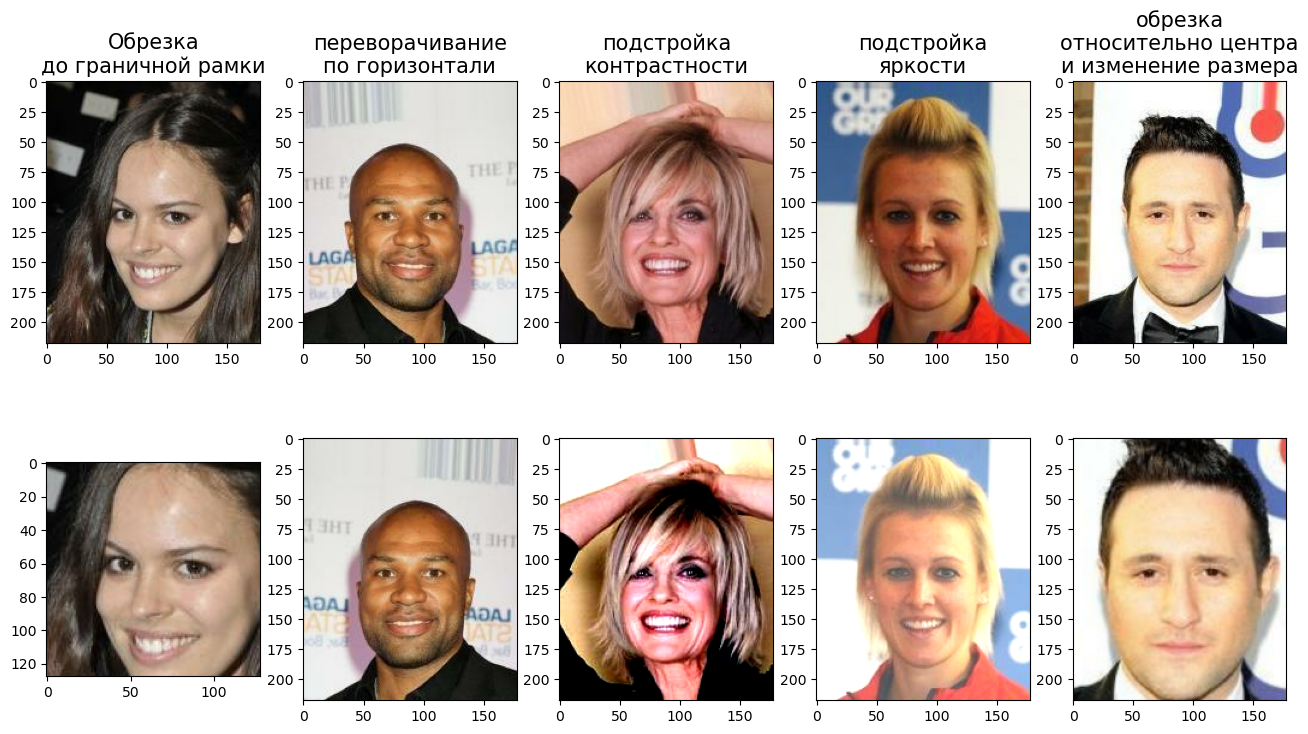

In [12]:
import matplotlib.pyplot as plt

examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))
# 1 обрезка до граничной рамки
ax = fig.add_subplot(2, 5, 1)
ax.set_title('Обрезка\nдо граничной рамки', size=15)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
img_cropped = tf.image.crop_to_bounding_box(examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

# 2 переворачивание по горизонтали
ax = fig.add_subplot(2, 5, 2)
ax.set_title('переворачивание\nпо горизонтали', size=15)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

# 3 подстройка контрастности
ax = fig.add_subplot(2, 5, 3)
ax.set_title('подстройка\nконтрастности', size=15)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
img_contrast = tf.image.adjust_contrast(examples[2], contrast_factor=2)
ax.imshow(img_contrast)

# 4 подстройка яркости
ax = fig.add_subplot(2, 5, 4)
ax.set_title('подстройка\nяркости', size=15)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
img_bright = tf.image.adjust_brightness(examples[3], delta=0.3)
ax.imshow(img_bright)

# 5 обрезка относительно центра и изменение размера
ax = fig.add_subplot(2, 5, 5)
ax.set_title('обрезка\nотносительно центра\nи изменение размера', size=15)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
img_center_crop = tf.image.central_crop(examples[4], central_fraction=0.7)
img_resized = tf.image.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))
plt.show()

Во время обучения модели, данные рекумендуется дополнять рандомизированно.

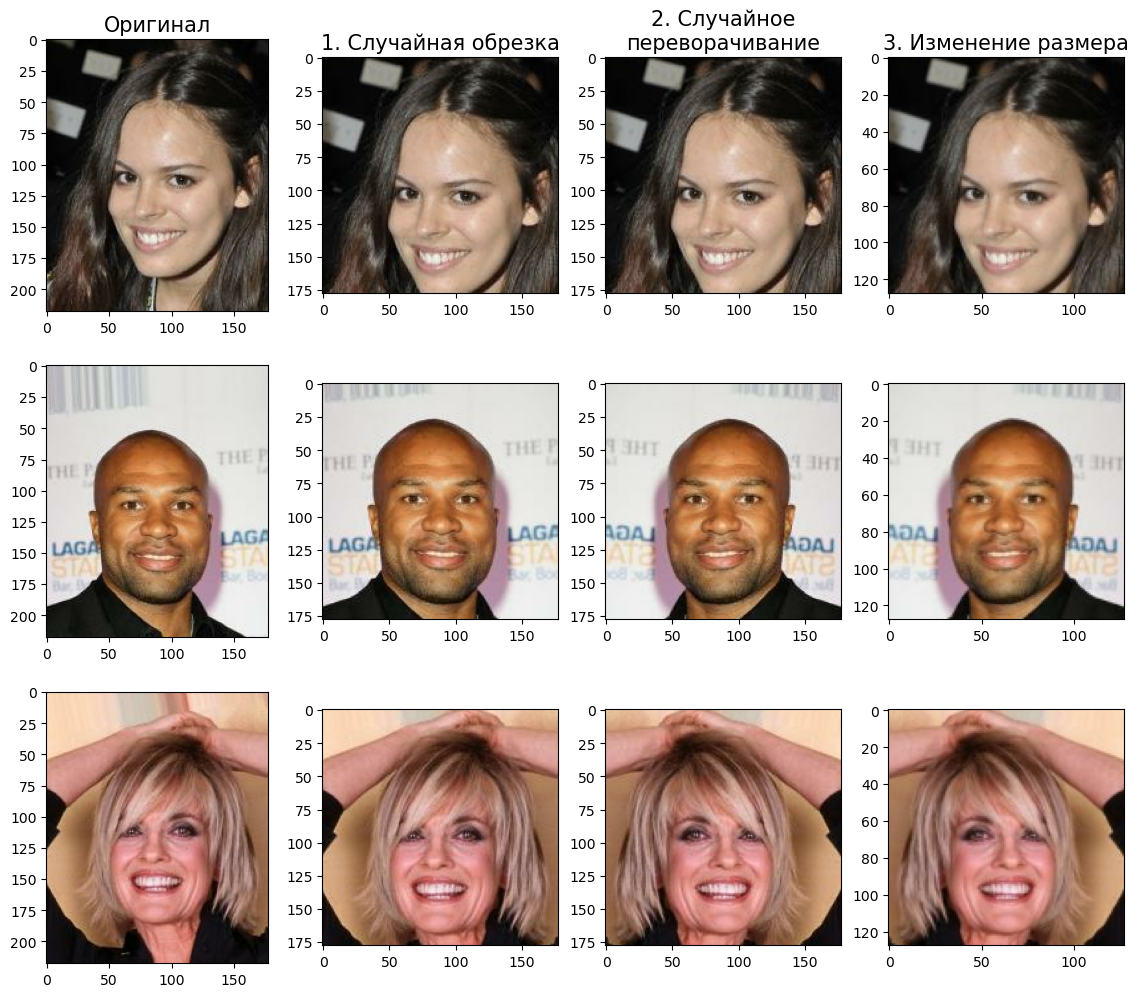

In [14]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))
for i, example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Оригинал', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('1. Случайная обрезка', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('2. Случайное\nпереворачивание', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('3. Изменение размера', size=15)
plt.show()

Конвейер дополнений для обучающих образцов:

In [15]:
def pad_preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(image, size=(178, 178, 3))
        image_resize = tf.image.resize(image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(image_resize)
        return image_flip/255., tf.cast(label, tf.int32)
    else:  # для не обучающих образцов
        image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20,
                                                      offset_width=0,
                                                      target_height=178,
                                                      target_width=178)
        image_resize = tf.image.resize(image_cropped, size=size)
        return image_resize/255., tf.cast(label, tf.int32)

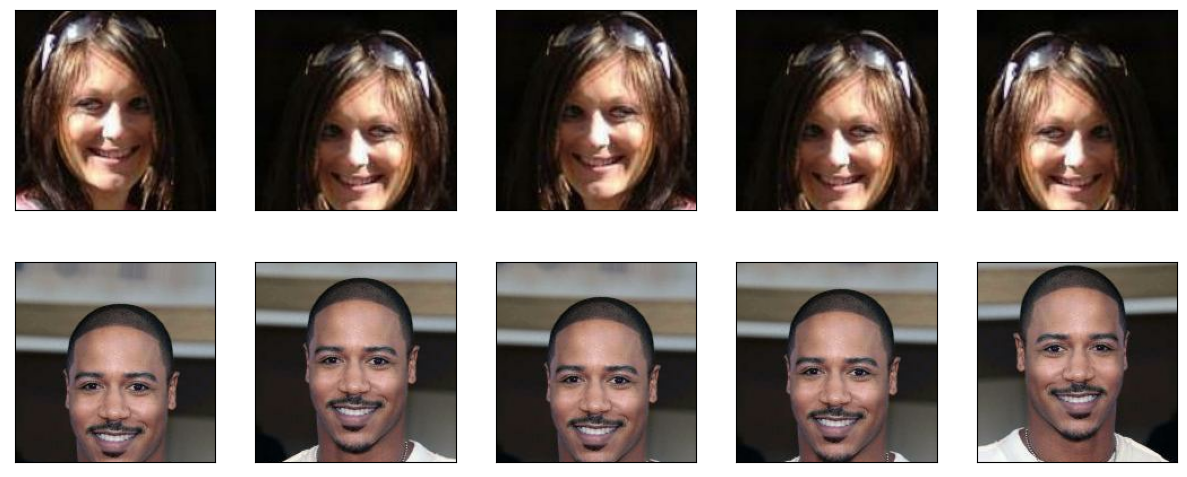

In [16]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.map(lambda x: pad_preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j % 2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
plt.show()

In [17]:
import numpy as np

BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)

ds_train = celeba_train.map(lambda x: pad_preprocess(x, size=IMAGE_SIZE,
                                                     mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(lambda x: pad_preprocess(x, size=IMAGE_SIZE,
                                                     mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
])

Выяснение формы выходных карт признаков:

In [19]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

Существуют 256 карт признаков (или каналов) размера 8 на 8.

Теперь мы можем добавить полносвязный слой, чтобы получить выходной слой с
единственным элементом. Если мы изменим форму карт признаков (выровняем их), тогда количество входных элементов в этом полносвязном слое
составит 8*8*256 = 16384. В качестве альтернативы мы возьмем новый
слой под названием слой объединения по глобальному среднему, который
рассчитывает среднее каждой карты признаков по отдельности, тем самым
сокращая количество скрытых элементов до 256. Затем мы можем добавить
полносвязный слой. Несмотря на то что мы явно не обсуждали слои объединения по глобальному среднему, концептуально они очень похожи на другие объединяющие слои. Фактически объединение по глобальному среднему
можно рассматривать как особый случай объединения по среднему, когда
размер объединения равен размеру входных карт признаков. 

Пример:
<img src='pic/avgpool.png' width='510'>

In [20]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [21]:
model.add(tf.keras.layers.Dense(1, activation=None))  # act=None - логиты

tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

Следующий шаг - компиляция модели. Теперь необходимо решить,
какую функцию потерь применять. Мы имеем двоичную классификацию
с одиночным выходным элементом, что означает необходимость в использовании класса BinaryCrossentropy. Кроме того, поскольку наш последний слой не применяет сигмоидальную активацию (activation=None), выходами модели являются логиты, не вероятности.
Таким образом, мы будем указывать в BinaryCrossentropy также и
from_logits=True, чтобы функция потерь внутренне применяла сигмоидальную функцию, которая благодаря своему лежащему в основе коду эффективнее, чем делать это вручную. 

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
500/500 [==============================] - 16s 17ms/step - loss: 0.6312 - accuracy: 0.6176 - val_loss: 0.5468 - val_accuracy: 0.6740
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5421 - accuracy: 0.7102 - val_loss: 0.5188 - val_accuracy: 0.6420
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4823 - accuracy: 0.7513 - val_loss: 0.4873 - val_accuracy: 0.8060
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.4413 - accuracy: 0.7818 - val_loss: 0.3599 - val_accuracy: 0.8180
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3835 - accuracy: 0.8147 - val_loss: 0.3041 - val_accuracy: 0.8850
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3287 - accuracy: 0.8441 - val_loss: 0.2322 - val_accuracy: 0.9190
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2899 - accuracy: 0.8626 - val_loss: 0.1804 - val_accuracy: 0.920

Text(0, 0.5, 'accuracy')

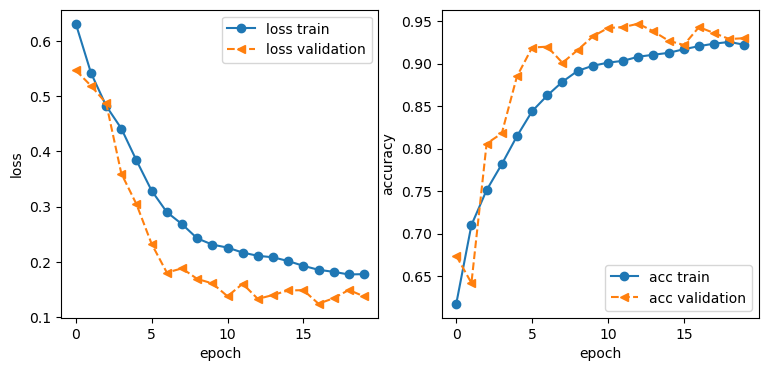

In [23]:
hist = history.history

x = np.arange(len(hist['loss']))

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(x, hist['loss'], '-o', label='loss train')
ax[0].plot(x, hist['val_loss'], '--<', label='loss validation')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(x, hist['accuracy'], '-o', label='acc train')
ax[1].plot(x, hist['val_accuracy'], '--<', label='acc validation')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

По кривым обучения несложно заметить, что потери при обучении и при проверки не сходятся в области плато. Базируясь на таком результате, мы могли бы продолжить обучение в течение еще нескольких эпох. Используя метод
fit(), мы можем продолжить обучение для дополнительных 10 эпох:

In [24]:
history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Epoch 21/30
500/500 [==============================] - 9s 17ms/step - loss: 0.1725 - accuracy: 0.9259 - val_loss: 0.1140 - val_accuracy: 0.9570
Epoch 22/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1668 - accuracy: 0.9289 - val_loss: 0.1283 - val_accuracy: 0.9300
Epoch 23/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1671 - accuracy: 0.9266 - val_loss: 0.1121 - val_accuracy: 0.9520
Epoch 24/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1640 - accuracy: 0.9295 - val_loss: 0.1816 - val_accuracy: 0.9070
Epoch 25/30
500/500 [==============================] - 8s 17ms/step - loss: 0.1600 - accuracy: 0.9302 - val_loss: 0.1216 - val_accuracy: 0.9510
Epoch 26/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1524 - accuracy: 0.9337 - val_loss: 0.1151 - val_accuracy: 0.9590
Epoch 27/30
500/500 [==============================] - 8s 16ms/step - loss: 0.1545 - accuracy: 0.9353 - val_loss: 0.1178 - val_accuracy:

Text(0, 0.5, 'accuracy')

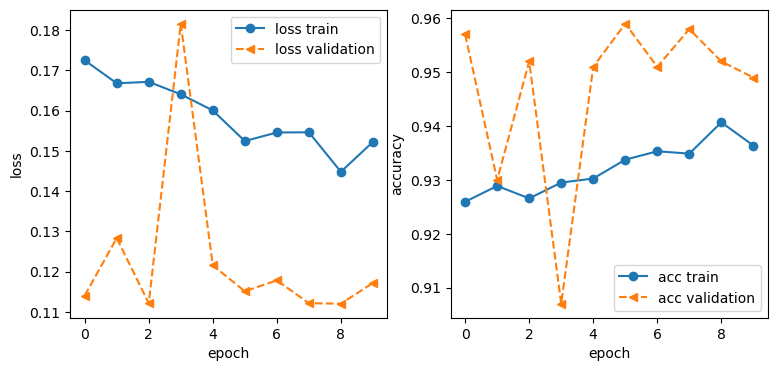

In [25]:
hist = history.history

x = np.arange(len(hist['loss']))

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(x, hist['loss'], '-o', label='loss train')
ax[0].plot(x, hist['val_loss'], '--<', label='loss validation')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(x, hist['accuracy'], '-o', label='acc train')
ax[1].plot(x, hist['val_accuracy'], '--<', label='acc validation')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

Также можно продолжить обучение.

Оценка модели на тестовом наборе:

In [26]:
ds_test = celeba_test.map(lambda x: pad_preprocess(x, size=IMAGE_SIZE,
                                                   mode='eval'))
ds_test = ds_test.batch(BATCH_SIZE)

test_results = model.evaluate(ds_test)
print('test accuracy:', test_results[1])

624/624 [==============================] - 3s 5ms/step - loss: 0.1176 - accuracy: 0.9457
test accuracy: 0.945746898651123


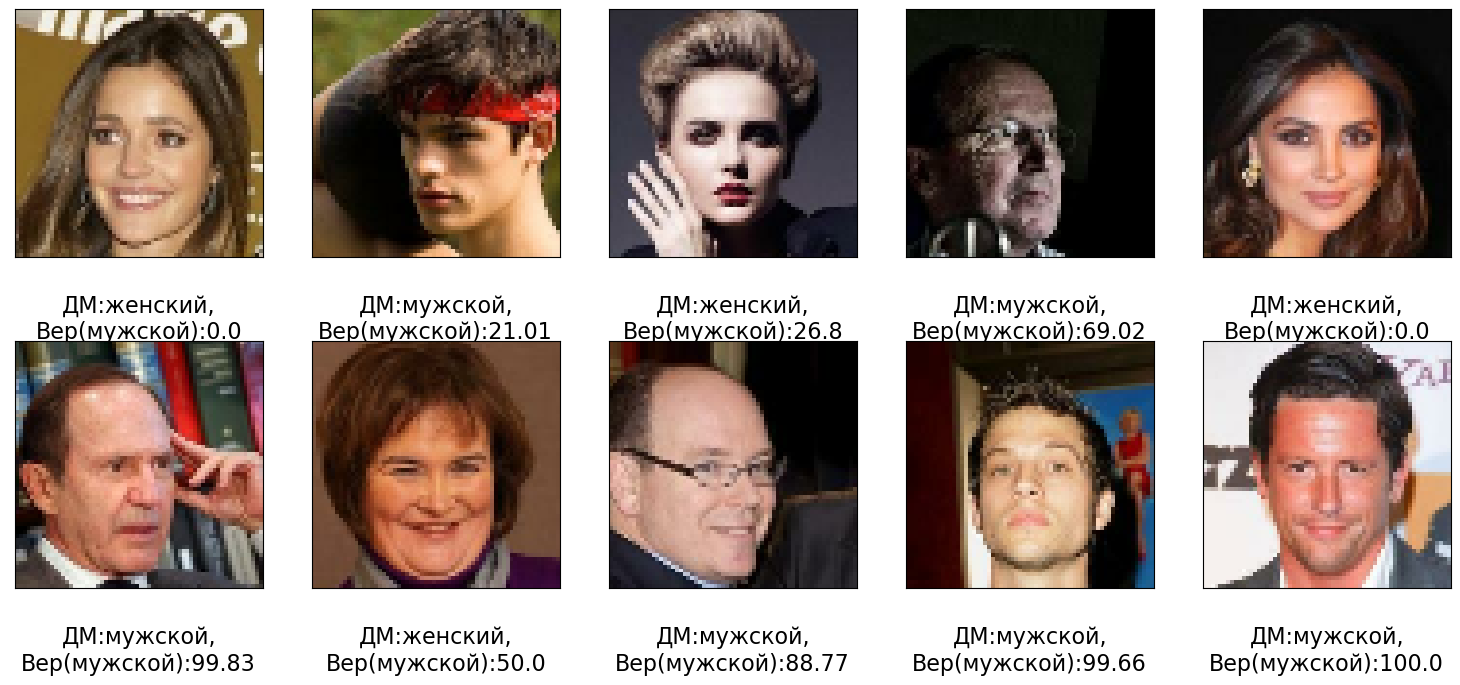

In [61]:
# Если не применить метод unbatch, тогда take возвратил бы 10 пакетов
# размера 32, а не 10 индивидуальных образцов

ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
probas = np.around(probas, decimals=2)

fig = plt.figure(figsize=(15, 7))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label = 'мужской'
    else:
        label = 'женский'
    ax.text(0.5, -0.25,
            f"ДМ:{label},\nВер(мужской):{float('{:.3f}'.format(probas[j]))}",
            size=16, horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.tight_layout()
plt.show()